In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In this project, I will be modeling the pickup and tone knob of an electric guitar. The pickup is an application of Faraday's Law, while the tone knob is an alternating current RC circuit, where the power supply is the output of the pickup. This will be broken down into several components, the first of which is to model a single guitar string vibrating over a single coil pickup.
The string will be modeled as a point-like magnetic dipole which has a moment of $1 \text{ Am}^2$. The strength of the dipole is essentially arbitrary, since we only care about the rate of change in flux, which really only depends on the frequency of vibration.

We can model the field around such a dipole using the vector equation below:
$$\vec{B} = \frac{1}{r^3}[3(\vec{\mu} \cdot \hat{r})\hat{r} - \vec{\mu}]$$

This allows us to easily model the vector value of the B field through the coil without having to worry about modeling the dipole as a current loop and having to integrate the Biot-Savart Law

We will start by creating a class to represent the coil with a single oscillating string. Later, we will be able to create an instance of this class for each string in order to model an entire six-string guitar.

The coil itself will be modeled as a square loop of wire, having many loops, but no physical thickness so that we can only worry about the flux through a plane, as opposed to many planes corresponding to many loops. While the closest end of the pickup is roughly 5 mm from the string, because we are treating all the loops of the wire to fit into the same space in the z dimension, we will say that the average location of the pickup coils is approximately 1.6 cm from the string.

Before we make the actual class for the pickup, it makes sense to make a helper class to hold all the relevant data for a point in this cross section.

In [2]:
def B(r, mu):
    '''Returns the vector for the B field at a point given r, the direction vector from the dipole,
       and mu, the vector form of the dipole moment'''
    r_mag = np.linalg.norm(r);
    r_hat = r / r_mag
    return 1/r_mag**3 * (3*(np.dot(mu, r_hat)*r_hat) - mu)

In [3]:
class Location:
    '''Contains the position vector and B field vector corresponding to a point in the plane of the coil'''
    def __init__(self, x, y):
        '''Initializes a point given an x and y coordinate (z is always zero)'''
        self.pos = np.array([x, y, 0])
        self.B = np.array([0, 0, 0])
        
    def update_B(self, mu, z):
        '''Calculates the B field vector at a point, given mu, the vector of the dipole moment,
            and z, the z coordinate of the string (we assume it only vibrates in the z dimension)
            Returns the change in the field as a vector'''
        r = np.array([self.pos[0], self.pos[1], -z])
        old = self.B
        self.B = B(r, mu)
        return self.B - old
    
    def update_flux(self, mu, z, dx):
        '''returns the change in flux at given point'''
        return self.update_B(mu, z)[2]*dx**2

In [4]:
class Pickup:
    '''Essentially houses a 2-D numpy arrays of Location objects and some other information, 
        such as the dimensions of the array, and the rest z coordinate of the string and the number of loops'''
    def __init__(self, mu_val, dt = 0.0002):
        self.N = 2000
        self.dx = 0.0001
        self.min = -0.002
        self.max = 0.002
        self.npoints = int((self.max - self.min)/self.dx)
        self.x = np.arange(self.min, self.max, self.dx)
        self.y = np.arange(self.min, self.max, self.dx)
        self.z0 = 0.015
        self.dt = dt
        self.mu = np.array([0, 0, mu_val])
        #Forgive me for being bad with numpy arrays, but the ways of C++ are too well engrained in 
        #my head for me to not use loops, even though I know they run slower
        self.plane = np.ndarray(shape = (self.npoints, self.npoints), dtype = Location)
        for (i, j), loc in np.ndenumerate(self.plane):
            x = self.min + i*self.dx
            
            y = self.min + j*self.dx
            
            self.plane[i][j] = Location(x, y)
            
    def get_dflux(self, mu, z):
        '''returns the change in flux through the plane given a dipole moment mu and dipole z coordinate'''
        dflux = 0
        for (i, j), loc in np.ndenumerate(self.plane):
            dflux += self.plane[i][j].update_flux(mu, z, self.dx)
        return dflux
    
    def induced_emf(self, mu, z, dt):
        '''returns the emf created at a given instantaneous position of the string. Functions called internally
            calculate the change in flux by comparing to the previous value of the B field'''
        return -1*self.N*self.get_dflux(mu,z)/dt
    
    def vibrate(self, vib_func, A, t_max=1):
        '''main driver function that outputs voltage over time given a vibration function and amplitude,
            t is assumed to start at zero and go until t_max, with step self.dt'''
        t_arr = np.arange(0, t_max, self.dt)
        V_arr = np.zeros(np.shape(t_arr))
        
        for i, t in enumerate(t_arr):
            z = vib_func(t, A) + self.z0
            V_arr[i] = self.induced_emf(self.mu, z, self.dt)
            if i == 0:
                V_arr[i] = 0
        return V_arr

In [5]:
def note_2low_E(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the 2nd E below middle C, or 82.41 Hz. This is the frequency of the bottom
        note of a guitar'''
    f = 82.41
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [6]:
def note_2low_A(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the 2nd A below middle C, or 110 Hz. This is the frequency of the bottom
        note of the second string of a guitar'''
    f = 110
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [7]:
def note_low_C(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the C below middle C, or 130.81 Hz. '''
    f = 130.81
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [8]:
def note_low_D(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the D below middle C, or 146.83 Hz. This is the frequency of the bottom
        note of the third string of a guitar'''
    f = 146.83
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [9]:
def note_low_E(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the E below middle C, or 164.81 Hz. '''
    f = 164.81
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [10]:
def note_low_G(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the G below middle C, or 196 Hz. This is the frequency of the bottom
        note of the fourth string of a guitar'''
    f = 196
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [11]:
def note_middle_B(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the B below middle C, or 246.94 Hz. This is the frequency of the bottom
        note of the fifth string of a guitar'''
    f = 246.94
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [12]:
def note_middle_C(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at middle C, or 261.63 Hz. This is the frequency of the bottom
        note of the fifth string of a guitar'''
    f = 261.63
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [13]:
def note_middle_E(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the E above middle C, or 329.63 Hz. This is the frequency of the bottom
        note of the highest string of a guitar'''
    f = 329.63
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [49]:
def note_middle_Gs(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the G# above middle C, or 415.30 Hz. '''
    f = 415.3
    omega = 2*np.pi*f
    z = A * np.sin(omega*t) * 2**(-t)
    
    return z

In [369]:
t_max = 0.5
V6 = pic6.vibrate(note_middle_E, 0.00025, t_max)

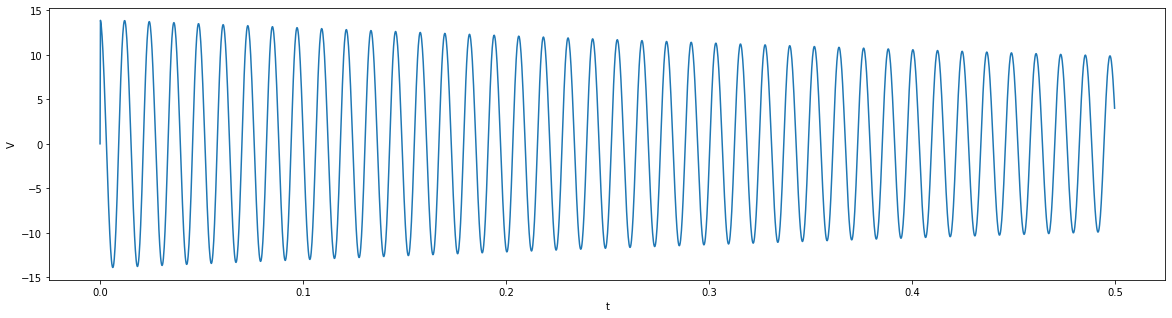

In [371]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V1)

Here we can see the output of the lowest string being plucked. Additionally, below is the highest string being plucked. This string is two octaves higher than the lowest string.

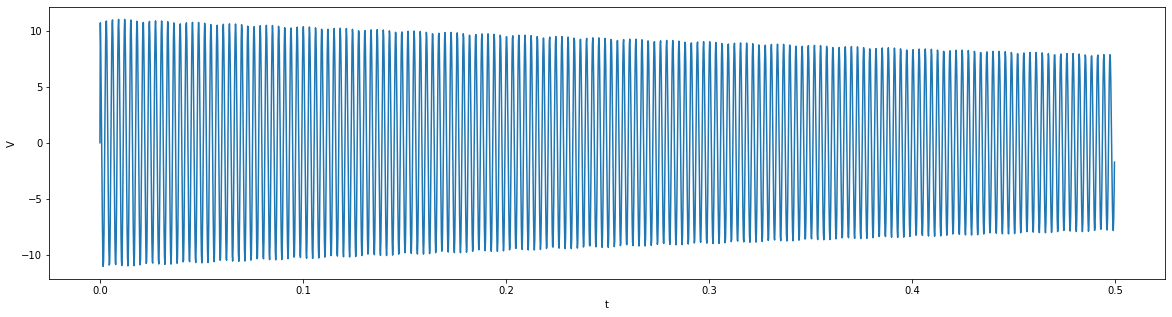

In [405]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V6)

In [17]:
pic1 = Pickup(3.01e-5)
pic2 = Pickup(2.71e-5)
pic3 = Pickup(2.11e-5)
pic4 = Pickup(1.5e-5)
pic5 = Pickup(9.03e-6)
pic6 = Pickup(6.02e-6)
t_max = 0.5
t = np.arange(0, t_max, pic1.dt)
V1 = pic1.vibrate(note_2low_E, 0.00025, t_max)
print("V1")
V2 = pic2.vibrate(note_2low_A, 0.00025, t_max)
print("V2")
V3 = pic3.vibrate(note_low_D, 0.00025, t_max)
print("V3")
V4 = pic4.vibrate(note_low_G, 0.00025, t_max)
print("V4")
V5 = pic5.vibrate(note_middle_B, 0.00025, t_max)
print("V5")
V6 = pic6.vibrate(note_middle_E, 0.00025, t_max)
print("V6")
V_open = V1 + V2 + V3 + V4 + V5 + V6

V1
V2
V3
V4
V5
V6


In [15]:
pic1b = Pickup(3.01e-5, 1e-5)
pic2b = Pickup(2.71e-5, 1e-5)
pic3b = Pickup(2.11e-5, 1e-5)
pic4b = Pickup(1.5e-5, 1e-5)
pic5b = Pickup(9.03e-6, 1e-5)
pic6b = Pickup(6.02e-6, 1e-5)
t_max = 0.02
tb = np.arange(0, t_max, pic1b.dt)
V1 = pic1b.vibrate(note_2low_E, 0.00025, t_max)
print("V1")
V2 = pic2b.vibrate(note_2low_A, 0.00025, t_max)
print("V2")
V3 = pic3b.vibrate(note_low_D, 0.00025, t_max)
print("V3")
V4 = pic4b.vibrate(note_low_G, 0.00025, t_max)
print("V4")
V5 = pic5b.vibrate(note_middle_B, 0.00025, t_max)
print("V5")
V6 = pic6b.vibrate(note_middle_E, 0.00025, t_max)
print("V6")
V_openb = V1 + V2 + V3 + V4 + V5 + V6

V1
V2
V3
V4
V5
V6


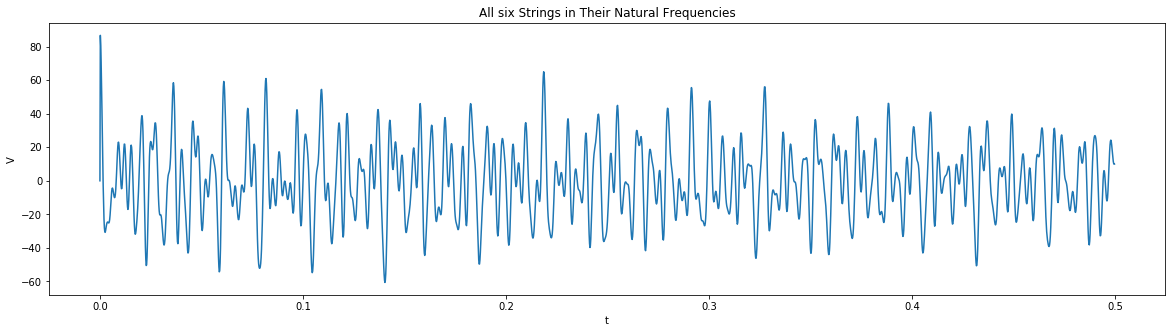

In [406]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("All six Strings in Their Natural Frequencies")
plt.plot(t, V_open)

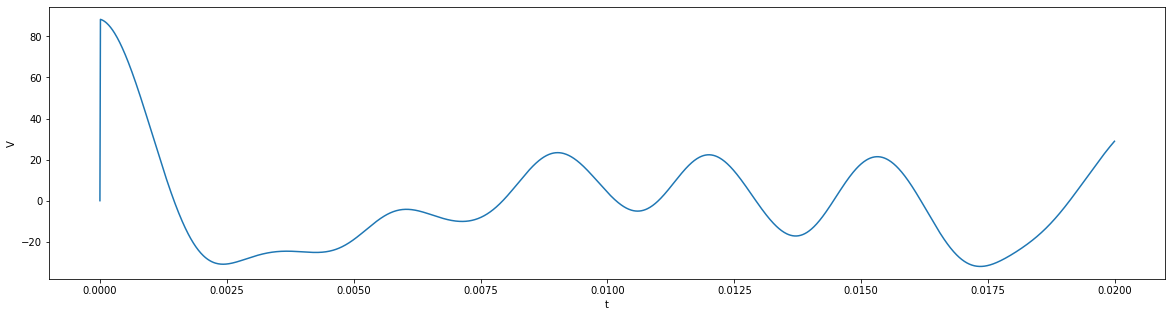

In [403]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_openb)

In [19]:
V2 = pic2.vibrate(note_low_C, 0.00025, t_max)
print("V2")
V3 = pic3.vibrate(note_low_E, 0.00025, t_max)
print("V3")
V4 = pic4.vibrate(note_low_G, 0.00025, t_max)
print("V4")
V5 = pic5.vibrate(note_middle_C, 0.00025, t_max)
print("V5")
V6 = pic6.vibrate(note_middle_E, 0.00025, t_max)
print("V6")
V_C_chord = V2 + V3 + V4 + V5 + V6

V2
V3
V4
V5
V6


In [22]:
t_max = 0.02
V2 = pic2b.vibrate(note_low_C, 0.00025, t_max)
print("V2")
V3 = pic3b.vibrate(note_low_E, 0.00025, t_max)
print("V3")
V4 = pic4b.vibrate(note_low_G, 0.00025, t_max)
print("V4")
V5 = pic5b.vibrate(note_middle_C, 0.00025, t_max)
print("V5")
V6 = pic6b.vibrate(note_middle_E, 0.00025, t_max)
print("V6")
V_C_chordb = V2 + V3 + V4 + V5 + V6

V2
V3
V4
V5
V6


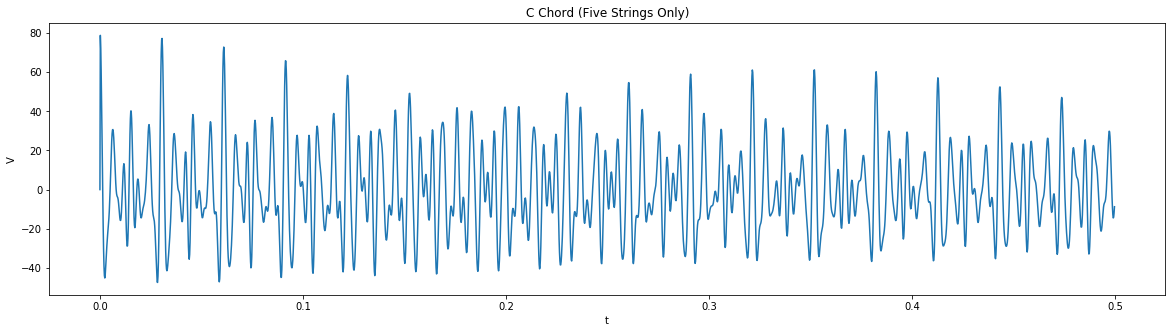

In [407]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("C Chord (Five Strings Only)")
plt.plot(t, V_C_chord)

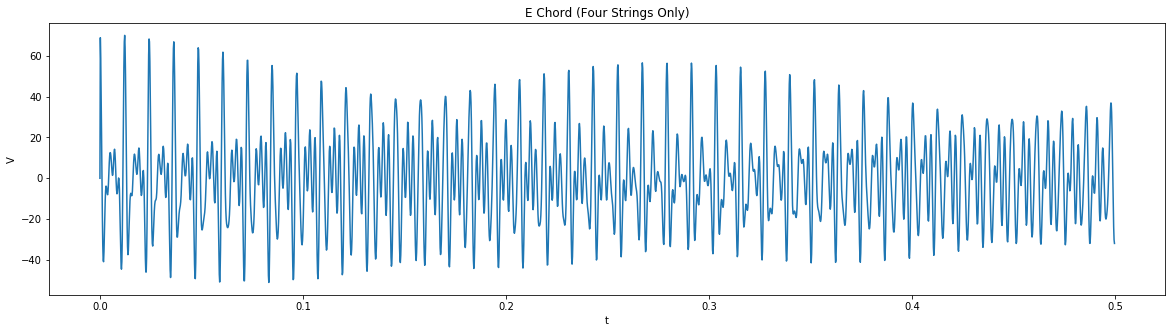

In [408]:
fig = plt.figure(figsize = [20, 5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("E Chord (Four Strings Only)")
plt.plot(t, V_E_chord)

In [51]:
t_max = 0.5
V3 = pic3.vibrate(note_low_E, 0.00025, t_max)
print("V3")
V4 = pic4.vibrate(note_middle_B, 0.00025, t_max)
print("V4")
V5 = pic5.vibrate(note_middle_E, 0.00025, t_max)
print("V5")
V6 = pic6.vibrate(note_middle_Gs, 0.00025, t_max)
print("V6")
V_E_chord = V3 + V4 + V5 + V6
t_max = 0.02
V3 = pic3b.vibrate(note_low_E, 0.00025, t_max)
print("V3")
V4 = pic4b.vibrate(note_middle_B, 0.00025, t_max)
print("V4")
V5 = pic5b.vibrate(note_middle_E, 0.00025, t_max)
print("V5")
V6 = pic6b.vibrate(note_middle_Gs, 0.00025, t_max)
print("V6")
V_E_chordb = V3 + V4 + V5 + V6

V3
V4
V5
V6
V3
V4
V5
V6


Now that we have generated some outputs from a pickup, it is time to run them through the tone knob. The tone knob consists of a potentiometer connected to a capacitor. As shown in the write up, we can simplify the circuit that consists of the tone and volume knobs to just a simple RC circuit if we set the volume to be constant. This gives us a circuit consisting of a resistor and capacitor in parallel with another resistor, all of which is connected to the pickup in series with another resistor. The function of the tone knob is to vary the resistance value of the resistor in series with the capacitor (this makes more sense when looking at a picture, as in the writeup). Such a circuit is governed by the following equations:

$$V(t) = R_1\frac{dQ_1}{dt} + R_2\frac{dQ_2}{dt} + Q_2C$$
$$R_3\frac{dQ_3}{dt} = R_2\frac{dQ_2}{dt} + Q_2C$$
$$\frac{dQ_1}{dt} = \frac{dQ_2}{dt} + \frac{dQ_3}{dt}$$

We can now use Euler's method to solve for the output voltage, $R_3 \frac{dQ_3}{dt}$. We will create a class to represent this circuit with a manipulatable value of $R_2$.

In our process function, we employ Euler's method to update $Q_2$ using the previous value of $\frac{dQ_2}{dt}$, which for ease of writing I will refer to as $I_2$ from this point. With knowledge of $Q_2$, we can treat $Q_2C$ as a constant, $V_C$, in determining the three currents. We are left with the following system of three equations:

$$R_1I_1 = V(t) - V_C - R_2I_2$$
$$R_3I_3 = R_2I_2 + V_C$$
$$I_1 = I_2 + I_3$$

This is, of course, a system of three equations with three unknowns, which means we can solve for each variable in terms of the constants. Solving for $I_2$, we can see that:

$$R_1(I_2 + I_3) = V(t) - V_C - R_2I_2$$

$$R_1(I_2 + \frac{R_2I_2 + V_C}{R_3}) = V(t) - V_C - R_2I_2$$

$$R_1I_2 + \frac{R_2}{R_3}I_2 + \frac{V_C}{R_3} = V(t) - V_C - R_2I_2$$

$$(R_1 + R_2 + \frac{R_2}{R_3})I_2 = V(t) - V_C - \frac{V_C}{R_3}$$

$$I_2 = \frac{V(t) - V_C - \frac{V_C}{R_3}}{R_1 + R_2 + \frac{R_2}{R_3}}$$

We can use this equation to find $I_2$, and then use that to find the other currents.

In [333]:
class Tone:
    def __init__(self, knob):
        '''knob is on a scale of 1 to 10, integer valued'''
        self.C = 0.4e-6
        self.R1 = 5500
        self.R2 = 250e3 - 25e3*knob
        self.R3 = 1e6
        
    def set_val(self, knob):
        self.R2 = 250e3 - 25e3*knob
        
    def process(self, V, dt):
        Q = 0
        I1 = 0
        I2 = 0
        I3 = 0
        
        V_post = np.zeros(np.shape(V))
        for inum, Vi in enumerate(V):
            Q = Q + I2*dt
            VC = Q/self.C
            
#             I2 = (Vi - VC)/(self.R1 + self.R2)
            
#             print(V_post[inum]/Vi)
            I2 = (Vi - VC - VC/self.R3)/(self.R1 + self.R2 + self.R2/self.R3)
            I3 = (I2*self.R2 + VC)/self.R3
            I1 = I2 + I3
#             V_post[inum] = I3*self.R3
            V_post[inum] = I2*self.R2 + VC
        return V_post

What follows are a plethora of plots, some of which are useful, some of which are not. Ones included in the writeup are titled, the rest are not. The order is pretty loose as well, and like I said not all of these are useful. However, why bother to remove them? They're interesting to look at if nothing else.

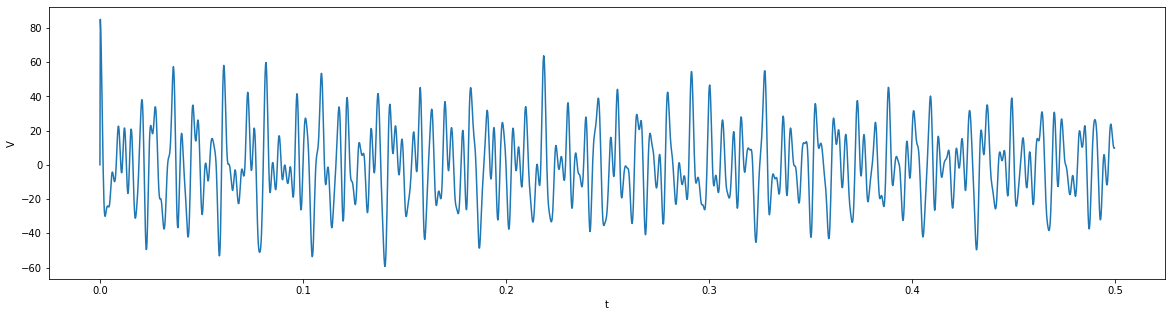

In [372]:
knob = Tone(0)
V_open_post0 = knob.process(V_open, pic1.dt)
V_open_post0b = knob.process(V_openb, pic1b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_open_post0)

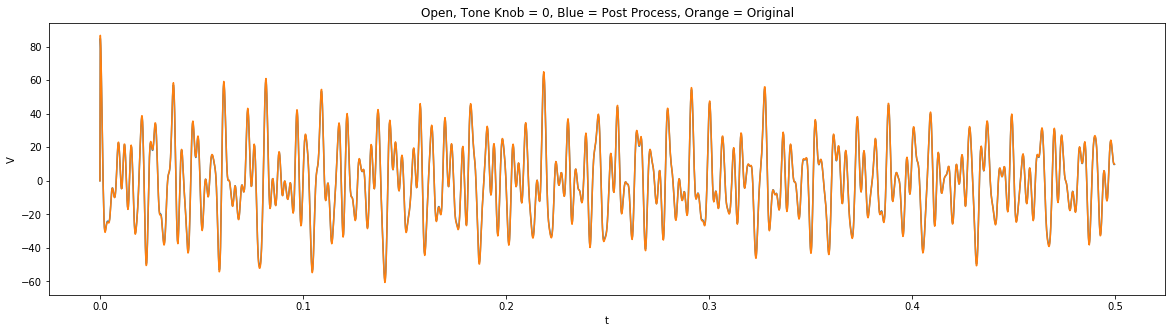

In [413]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("Open, Tone Knob = 0, Blue = Post Process, Orange = Original")

plt.plot(t, V_open_post0, t, V_open)

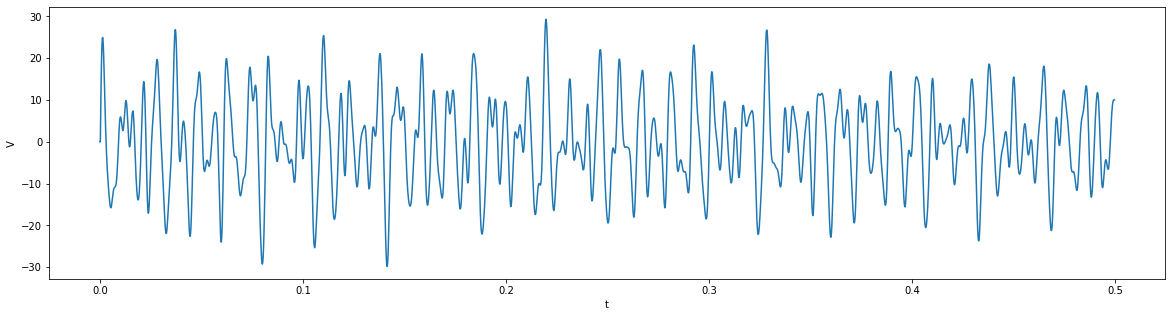

In [374]:
knob.set_val(10)
V_open_post10 = knob.process(V_open, pic1.dt)
V_open_post10b = knob.process(V_openb, pic1b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_open_post10)

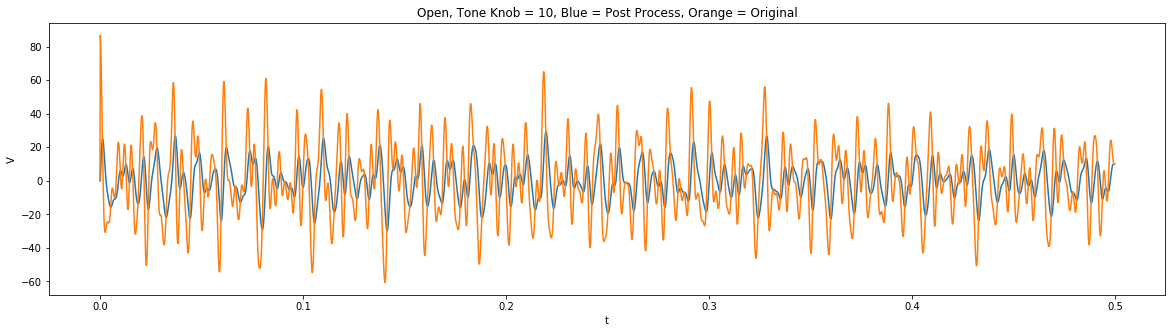

In [415]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("Open, Tone Knob = 10, Blue = Post Process, Orange = Original")
plt.plot(t, V_open_post10, t, V_open)

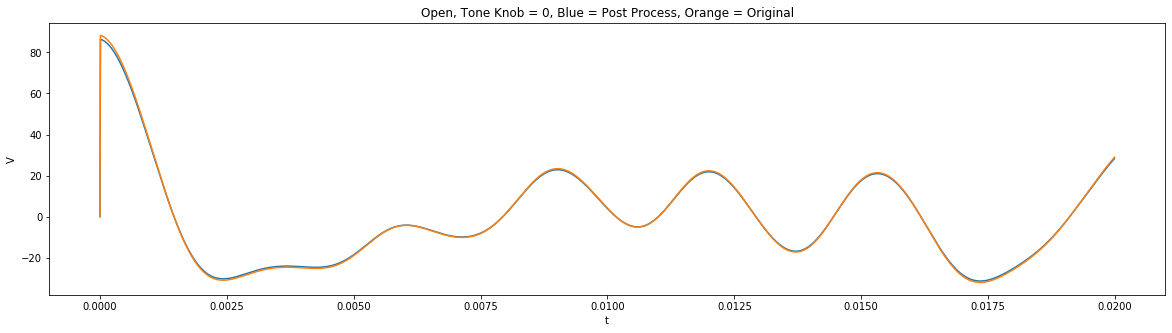

In [414]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("Open, Tone Knob = 0, Blue = Post Process, Orange = Original")

plt.plot(tb, V_open_post0b, tb, V_openb)

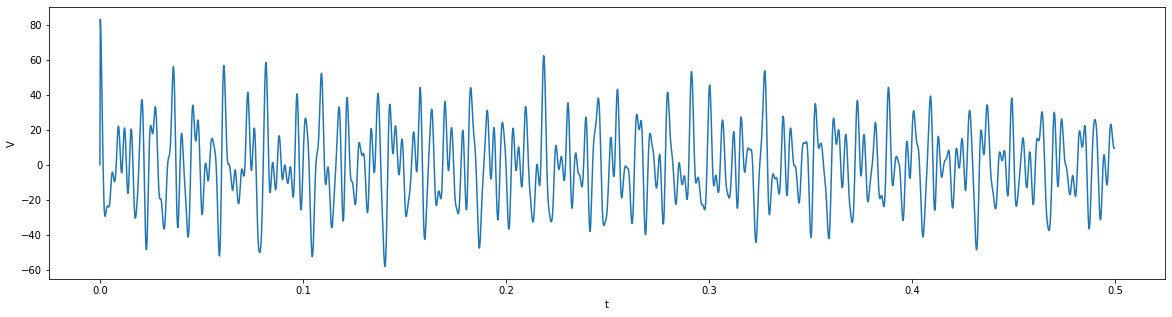

In [377]:
knob.set_val(5)
V_open_post5 = knob.process(V_open, pic1.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_open_post5)

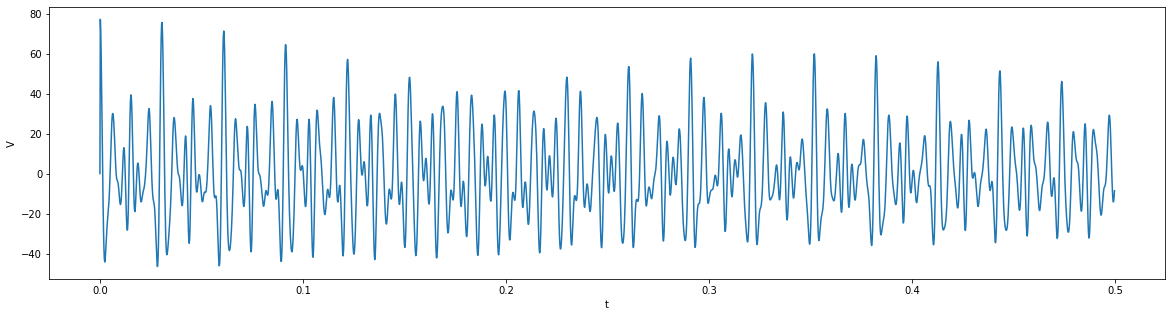

In [378]:
knobC = Tone(0)
V_C_chord_post0 = knobC.process(V_C_chord, pic2.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post0)

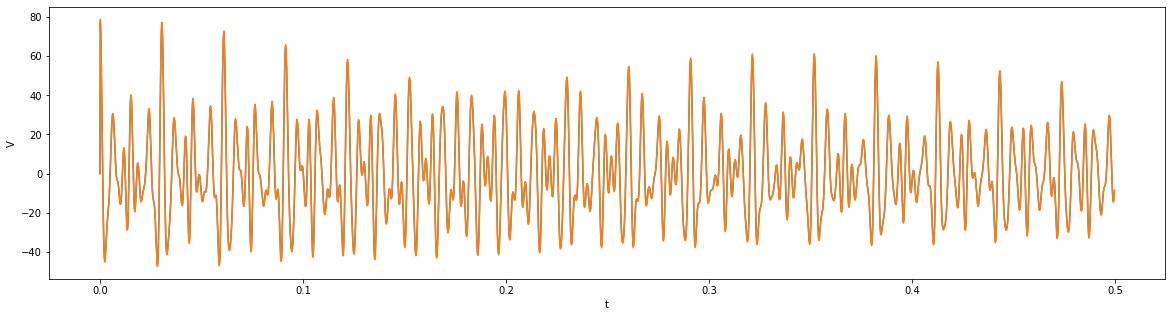

In [379]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post0, t, V_C_chord)

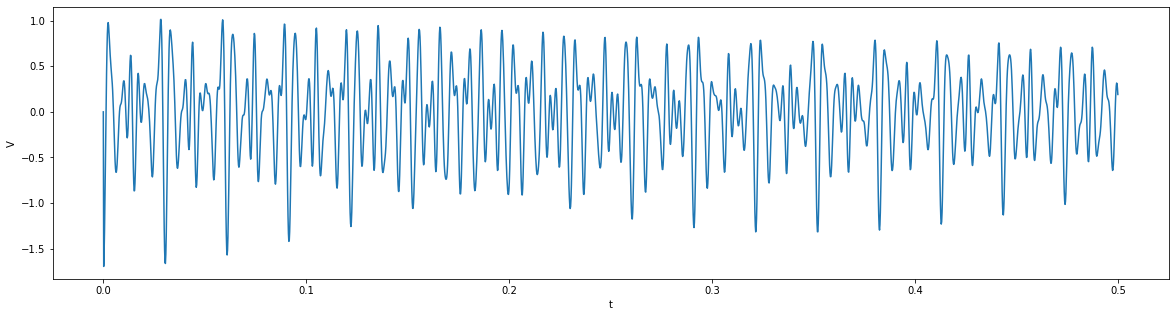

In [380]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post0 - V_C_chord)

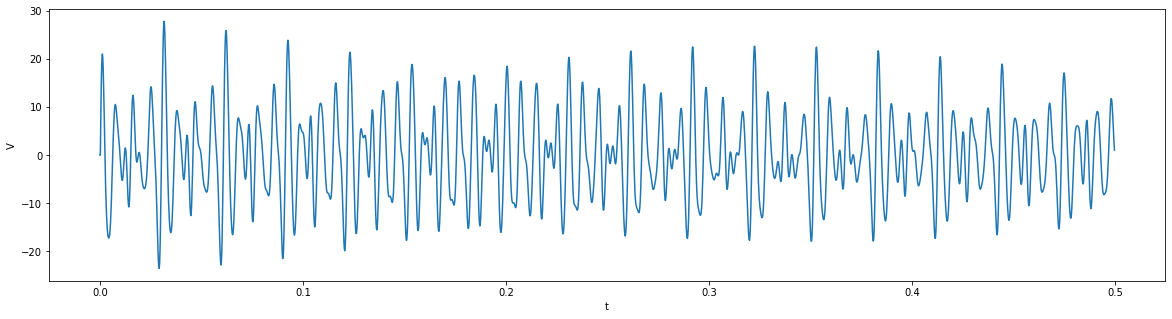

In [381]:
knobC.set_val(10)
V_C_chord_post10 = knobC.process(V_C_chord, pic2.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post10)

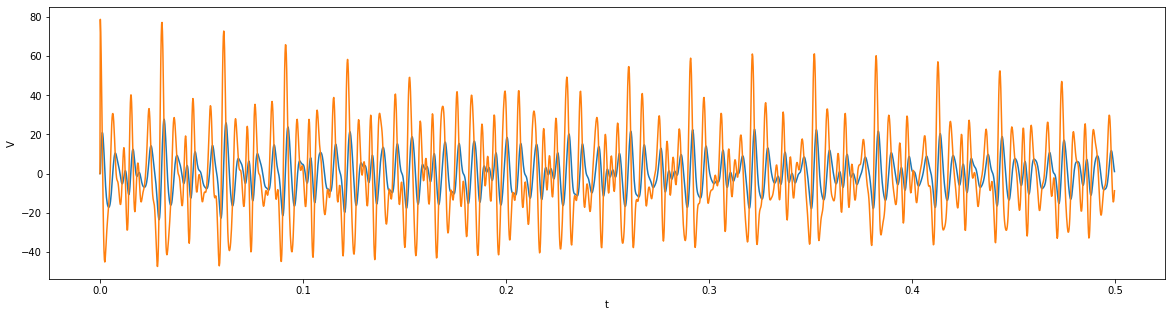

In [382]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post10, t, V_C_chord)

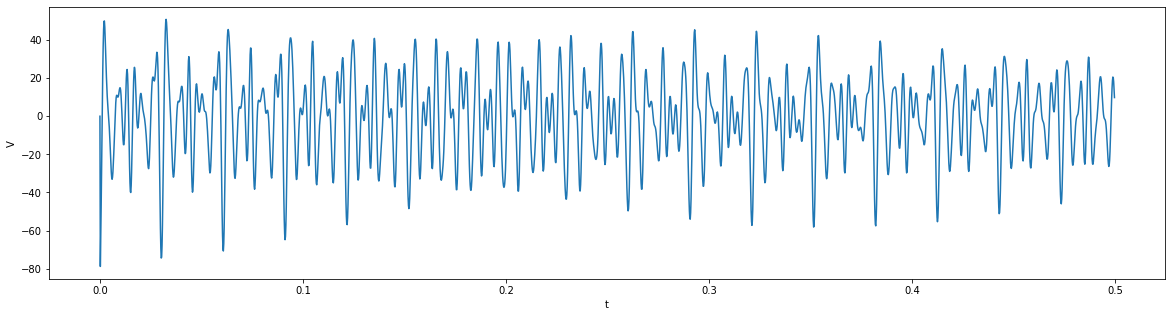

In [383]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_C_chord_post10 - V_C_chord)

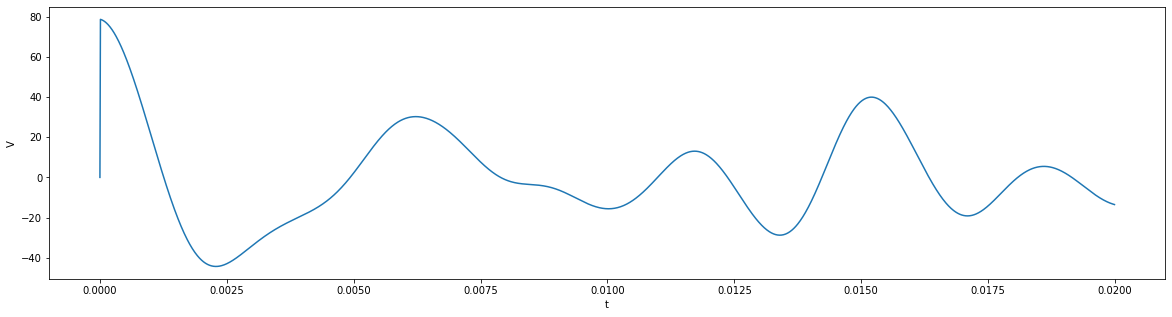

In [384]:
knobC = Tone(0)
V_C_chord_post0b = knobC.process(V_C_chordb, pic2b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post0b)

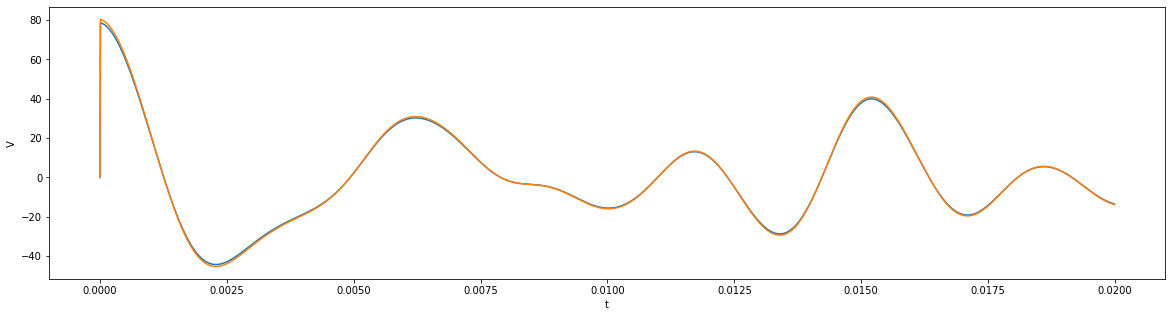

In [385]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post0b, tb, V_C_chordb)

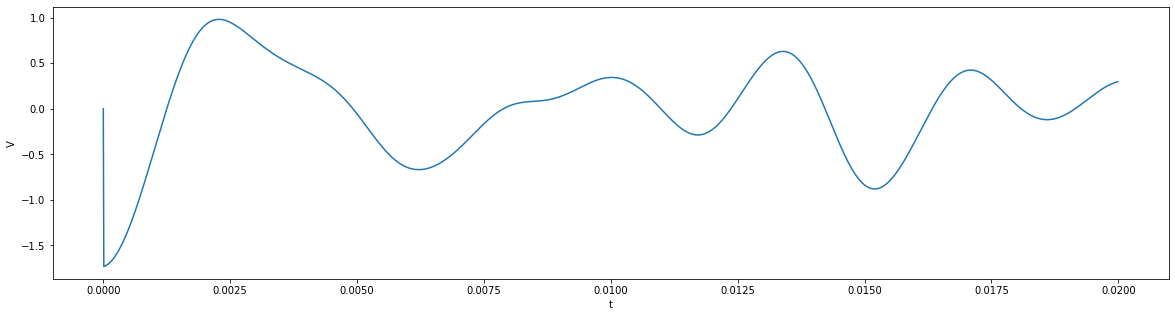

In [386]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post0b - V_C_chordb)

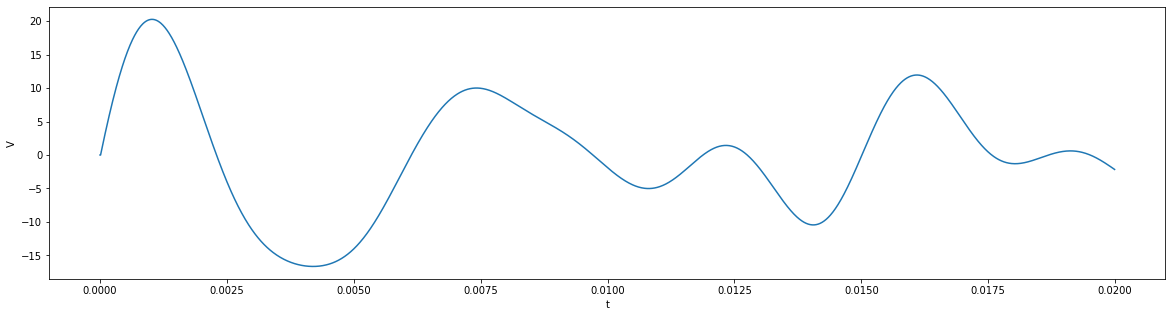

In [387]:
knobC.set_val(10)
V_C_chord_post10b = knobC.process(V_C_chordb, pic2b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post10b)

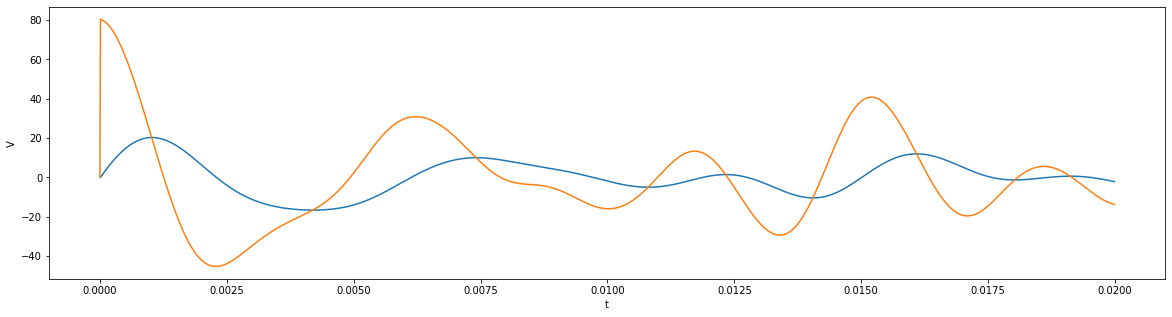

In [388]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post10b, tb, V_C_chordb)

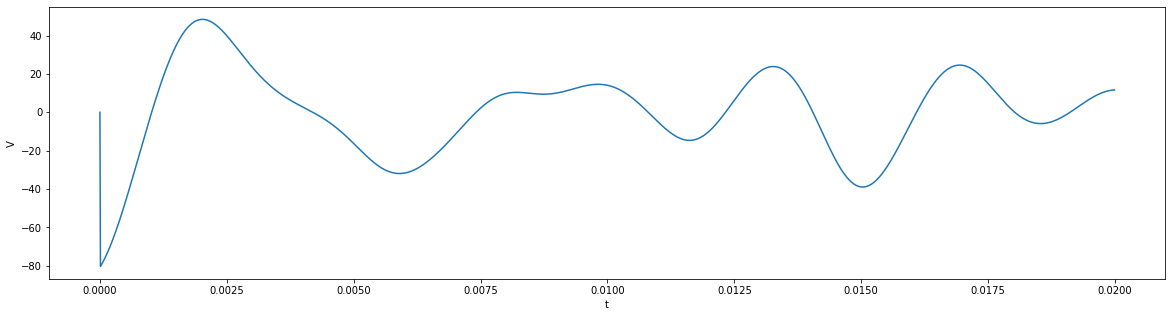

In [389]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_C_chord_post10b - V_C_chordb)

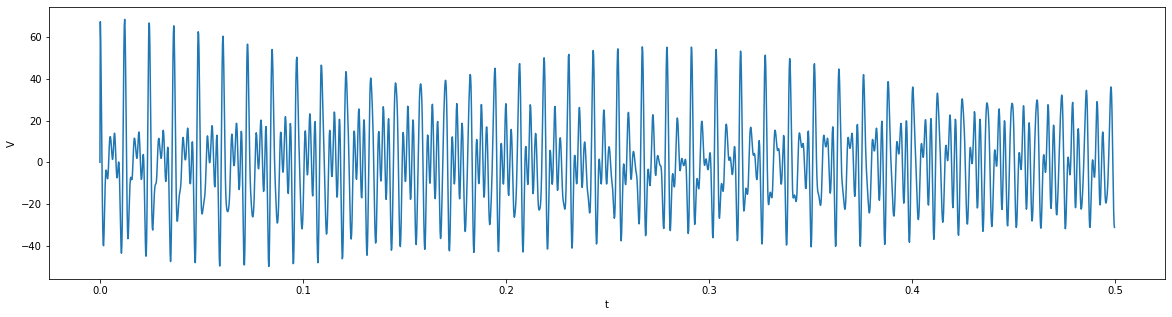

In [390]:
knobE = Tone(0)
V_E_chord_post0 = knobE.process(V_E_chord, pic3.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_E_chord_post0)

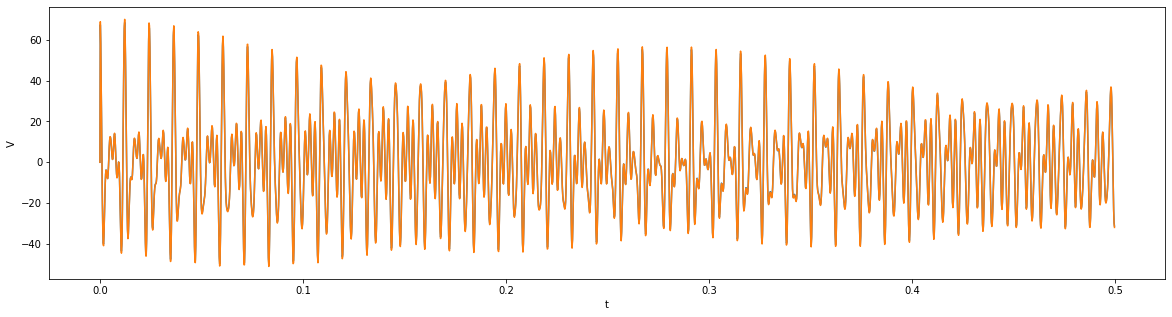

In [391]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_E_chord_post0, t, V_E_chord)

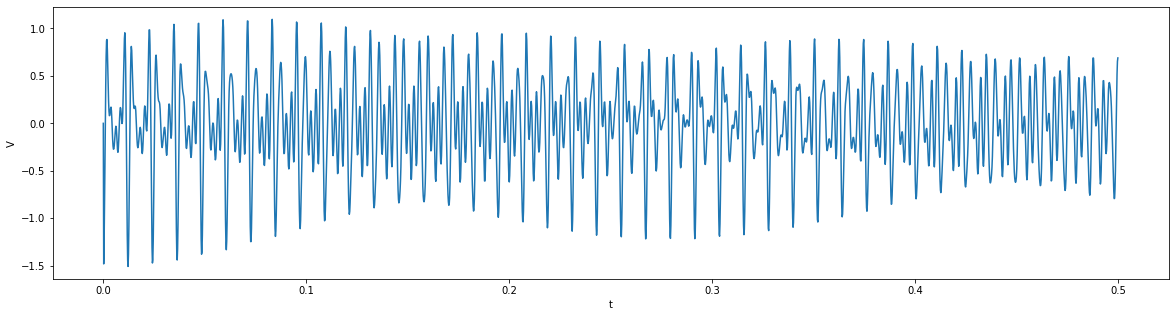

In [392]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_E_chord_post0 - V_E_chord)

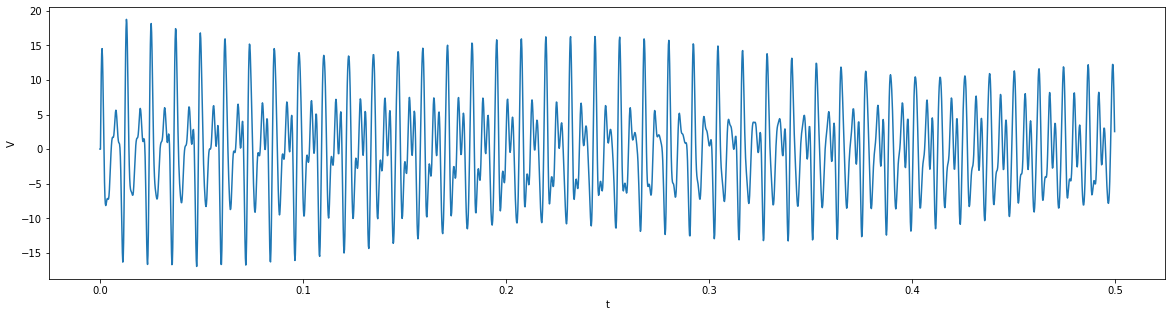

In [393]:
knobE.set_val(10)
V_E_chord_post10 = knobE.process(V_E_chord, pic3.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_E_chord_post10)

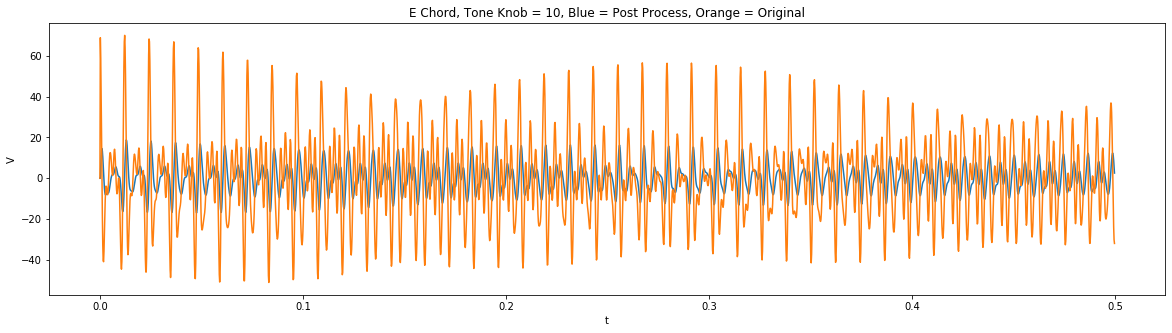

In [418]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("E Chord, Tone Knob = 10, Blue = Post Process, Orange = Original")
plt.plot(t, V_E_chord_post10, t, V_E_chord)

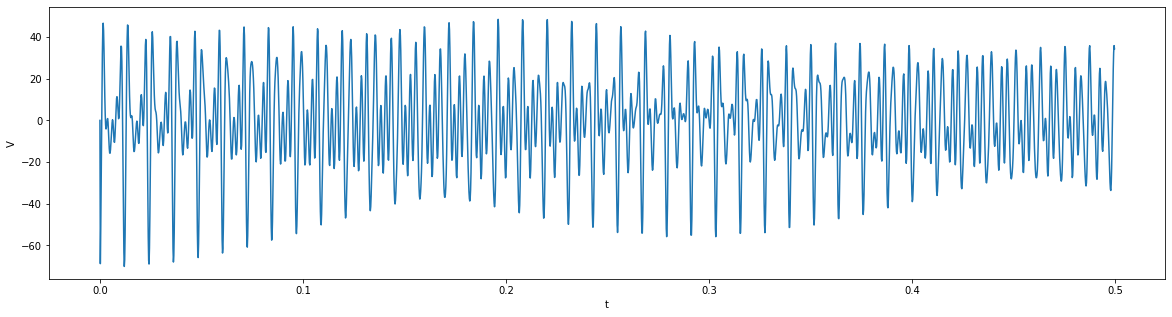

In [395]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(t, V_E_chord_post10 - V_E_chord)

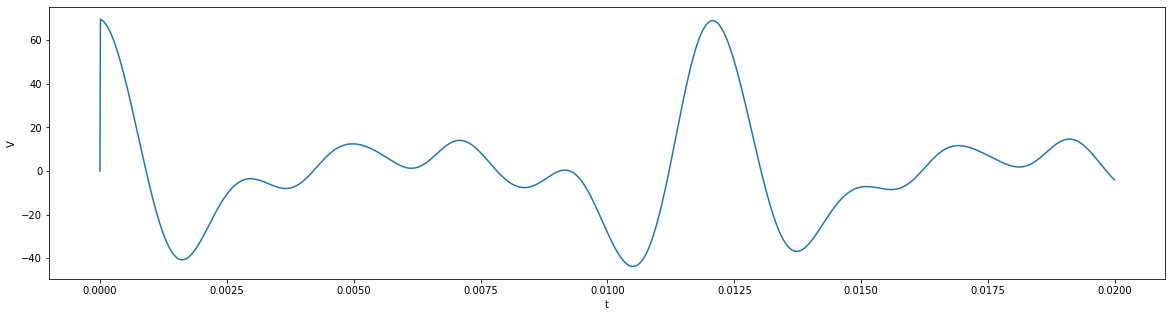

In [396]:
knobE = Tone(0)
V_E_chord_post0b = knobE.process(V_E_chordb, pic3b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_E_chord_post0b)

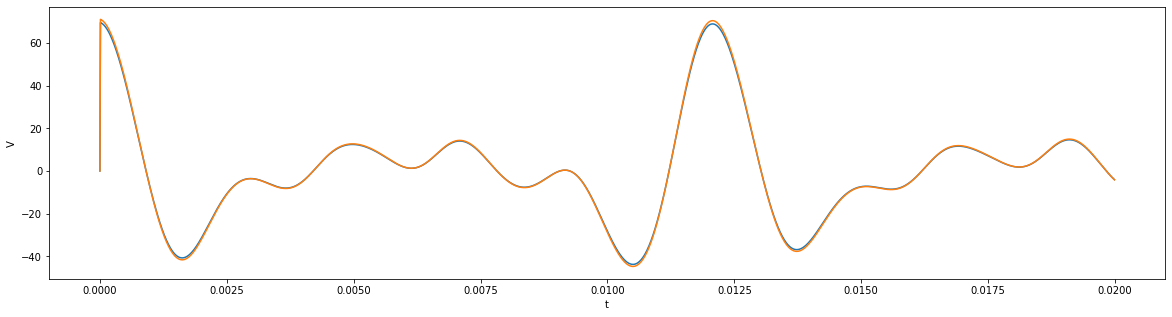

In [397]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_E_chord_post0b, tb, V_E_chordb)

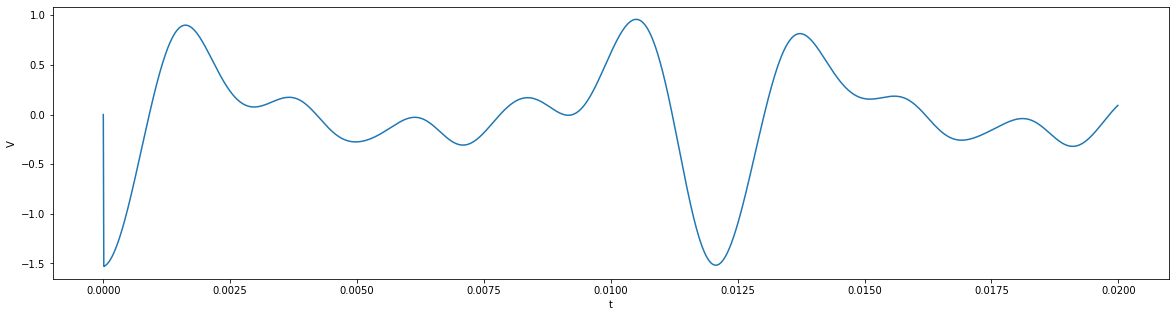

In [398]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_E_chord_post0b - V_E_chordb)

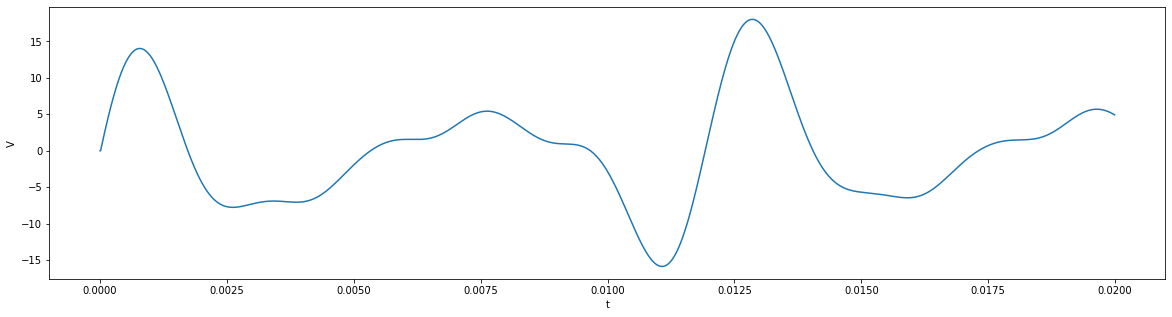

In [399]:
knobE.set_val(10)
V_E_chord_post10b = knobE.process(V_E_chordb, pic3b.dt)
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_E_chord_post10b)

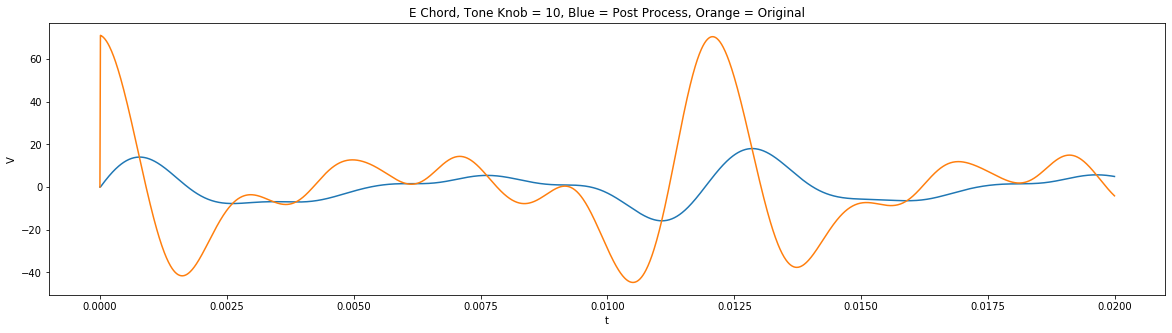

In [419]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.title("E Chord, Tone Knob = 10, Blue = Post Process, Orange = Original")
plt.plot(tb, V_E_chord_post10b, tb, V_E_chordb)

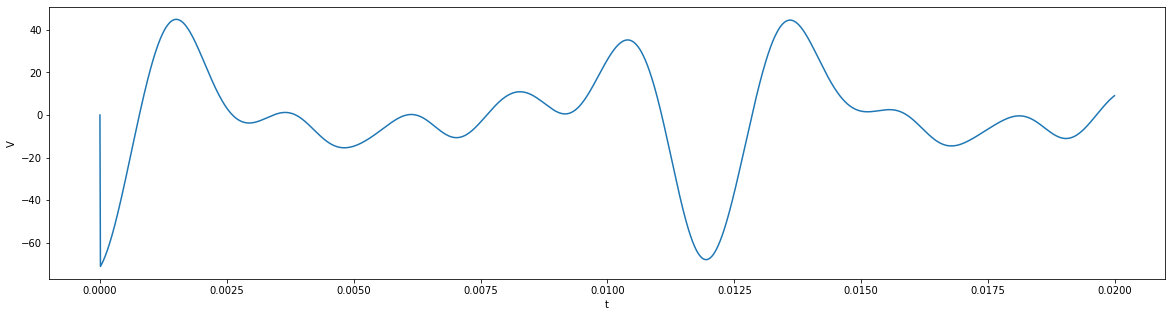

In [401]:
fig = plt.figure(figsize = [20,5])
plt.xlabel("t")
plt.ylabel("V")
plt.plot(tb, V_E_chord_post10b - V_E_chordb)